[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roman807/TGS_Salt/blob/master/Amol_15Oct.ipynb)

Unet: train model and evaluate results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras import optimizers
from keras import backend as K
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
from google.colab import files
import tensorflow as tf
import cv2
import os
import json
import zipfile
import skimage.io as io
import skimage.transform as trans
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import h5py

Using TensorFlow backend.


In [2]:
##### Use kaggle API
!pip install kaggle
api_token = {"username":"romanm87","key":"daa9da19c31bf091978760ad6eb373f3"}

os.chdir('/')
!mkdir ~/.kaggle #kaggle API searches in root directory for .kaggle/kaggle.json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

# API link from Kaggle:
!kaggle competitions download -c tgs-salt-identification-challenge
zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall()
zip_ref.close()

    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 235kB 7.1MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify
  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 65.5MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 77.4MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 75.1MB/s]
 99% 162M/163M [00:06<00:00, 22.4MB/s]
100% 163M/163M [00:06<00:00, 24.8MB/s]
 95% 36.0M/37.9M [00:00<00:00, 36.7MB/s]
100% 37.9M/37.9M [00:00<00:00, 72.1MB/s]


In [0]:
##### Prepare data
tr_image_dir = os.chdir('/images')
train_im = os.listdir(tr_image_dir)
x = np.array([np.array(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) for p in train_im]) / 255
#x_t = [np.transpose(i) for i in x]
#x_t = np.flip(x, 2)

tr_masks_dir = os.chdir('/masks')
train_ma = os.listdir(tr_masks_dir)
y = np.array([np.array(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) for p in train_ma]) / 255
#y_t = [np.transpose(i) for i in y]
#y_t = np.flip(y, 2)


##### Does adding transposes help?
# x = np.append(x, x_t, axis=0)
# y = np.append(y, x_t, axis=0)

# expand dimensions for CNN
x = np.expand_dims(x, axis=3)
y = np.expand_dims(y, axis=3)


x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.05, random_state=42)


# split training vs validation set
# train_val_split = 0.1
# x_train = x[0:int(x.shape[0]*(1-train_val_split)),:,:,:]
# y_train = y[0:int(y.shape[0]*(1-train_val_split)),:,:,:]
# x_val = x[int(x.shape[0]*(1-train_val_split)):,:,:,:]
# y_val = y[int(y.shape[0]*(1-train_val_split)):,:,:,:]

In [0]:
# plt.imshow(x[4000,:,:,0])
# train_tes

In [0]:
# plt.imshow(x[0,:,:,0])

In [0]:
#### define model
def unet(pretrained_weights=None, input_size=(101,101,1)):
    
    inputs = Input(input_size)
    input_padded = ZeroPadding2D(padding=((14, 13), (14, 13)))(inputs)  ## use zero padding to match dims after maxpool/upsample

#   conv  = Conv2D(filters, kernel_size, activation, padding, kernel_initializer)(input)
    conv1 = Conv2D(32, 5, activation='relu', padding='same', kernel_initializer='he_normal')(input_padded)
    conv1 = Conv2D(32, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = Conv2D(32, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = Conv2D(32, 5, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv1)

    conv2 = Conv2D(64, 5, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = Conv2D(64, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = Conv2D(64, 5, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv2)
    
    conv3 = Conv2D(128, 5, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = Conv2D(128, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = Conv2D(128, 5, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv3)
    
    conv4 = Conv2D(256, 5, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = Conv2D(256, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = Conv2D(256, 5, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv4)
    
    conv5 = Conv2D(512, 5, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = Conv2D(512, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = Conv2D(512, 5, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2), padding="same")(conv5)
    
    conv6 = Conv2D(1024, 5, activation='relu', padding='same', kernel_initializer='he_normal')(pool5)
    conv6 = Conv2D(1024, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = Conv2D(1024, 4, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = Conv2D(1024, 5, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = merge([conv5,up6], mode='concat', concat_axis = 3)
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = merge([conv3,up8], mode='concat', concat_axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = merge([conv2,up9], mode='concat', concat_axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    up10 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv9))
    merge10 = merge([conv1,up10], mode='concat', concat_axis=3)
    conv10 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge10)
    conv10 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)
    conv01 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)
    
    conv11 = Conv2D(1, 1, activation='sigmoid')(conv10)
    crop = Cropping2D(cropping=((14, 13), (14, 13)))(conv11)
    model = Model(inputs=inputs, output=crop)

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)
    return model

# kernel_size = 3
# def unet(pretrained_weights = None, input_size=(101,101,1), ks=kernel_size):
#     inputs = Input(input_size)
#     input_padded = ZeroPadding2D(padding=((14, 13), (14, 13)))(inputs)  ## use zero padding to match dims after maxpool/upsample
#     conv1 = Conv2D(64, ks, activation='relu', padding='same', kernel_initializer='he_normal')(input_padded)
#     conv1 = Conv2D(64, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
#     conv1 = Conv2D(64, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
#     conv1 = Conv2D(64, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv1)
#     conv2 = Conv2D(128, ks, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
#     conv2 = Conv2D(128, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
#     conv2 = Conv2D(128, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
#     conv2 = Conv2D(128, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv2)
#     conv3 = Conv2D(256, ks, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
#     conv3 = Conv2D(256, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
#     conv3 = Conv2D(256, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
#     conv3 = Conv2D(256, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv3)
#     conv4 = Conv2D(512, ks, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
#     conv4 = Conv2D(512, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
#     conv4 = Conv2D(512, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
#     conv4 = Conv2D(512, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv4)#(drop4)
#     conv5 = Conv2D(1024, ks, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
#     conv5 = Conv2D(1024, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
#     conv5 = Conv2D(1024, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
#     conv5 = Conv2D(1024, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
#     up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv5))
#     merge6 = merge([conv4,up6], mode='concat', concat_axis = 3)
#     conv6 = Conv2D(512, ks, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
#     conv6 = Conv2D(512, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
#     conv6 = Conv2D(512, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
#     conv6 = Conv2D(512, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
#     up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
#     merge7 = merge([conv3,up7], mode='concat', concat_axis = 3)
#     conv7 = Conv2D(256, ks, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
#     conv7 = Conv2D(256, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
#     conv7 = Conv2D(256, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
#     conv7 = Conv2D(256, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
#     up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
#     merge8 = merge([conv2,up8], mode='concat', concat_axis=3)
#     conv8 = Conv2D(128, ks, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
#     conv8 = Conv2D(128, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
#     conv8 = Conv2D(128, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
#     conv8 = Conv2D(128, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
#     up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
#     merge9 = merge([conv1,up9], mode='concat', concat_axis=3)
#     conv9 = Conv2D(64, ks, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
#     conv9 = Conv2D(64, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
#     conv9 = Conv2D(64, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
#     conv9 = Conv2D(64, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
#     conv9 = Conv2D(2, ks, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
#     conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
#     crop = Cropping2D(cropping=((14, 13), (14, 13)))(conv10)
#     model = Model(inputs=inputs, output=crop)
#     if(pretrained_weights):
#     	model.load_weights(pretrained_weights)
#     return model

In [0]:
##### Define evaluation metrics [NOT IN USE]
# class MeanIoU(object):
#     def __init__(self):
#         super().__init__()
#     def mean_iou(self, y_true, y_pred):
#         # Wraps np_mean_iou method and uses it as a TensorFlow op.
#         # Takes numpy arrays as its arguments and returns numpy arrays as outputs
#         return tf.py_func(self.np_mean_iou, [y_true, y_pred], tf.float64)
#     def np_mean_iou(self, y_true, y_pred):
#         y_pred = np.round(y_pred + 0.05, 0).reshape(-1)
#         y_true = y_true.reshape(-1)        
#         conf = confusion_matrix(y_pred, y_true)        
#         # Compute the IoU and mean IoU from the confusion matrix:
#         true_positive = conf[1,1]
#         false_positive = conf[1,0]
#         false_negative = conf[0,1]
#         # Just in case we get a division by 0, ignore/hide the error and set the value to 0
#         with np.errstate(divide='ignore', invalid='ignore'):
#             iou = true_positive / (true_positive + false_positive + false_negative)
#         #iou[np.isnan(iou)] = 0
#         return np.mean(iou).astype(np.float64)
# miou = MeanIoU()
# def bin_acc05(y_true, y_pred):
#     return K.mean(K.equal(y_true, K.round(y_pred + 0.05)), axis=-1)

In [10]:
##### Define model 
model = unet()
an_optimizer = optimizers.adam(lr = 0.0001)
model.compile(loss = 'binary_crossentropy', optimizer=an_optimizer, metrics=['accuracy'])
#model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: The `m

In [0]:
# ##### Run model
# filepath = 'weights.best.hdf5'
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]
# model.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_val,y_val), callbacks=callbacks_list, verbose=1)

In [12]:
##### Run model
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val,y_val), verbose=1)

Train on 3800 samples, validate on 200 samples
Epoch 1/10
3800/3800 [==============================] - 77s 20ms/step - loss: 0.6840 - acc: 0.7540 - val_loss: 0.6848 - val_acc: 0.7143
Epoch 2/10
3800/3800 [==============================] - 77s 20ms/step - loss: 0.6825 - acc: 0.7540 - val_loss: 0.6836 - val_acc: 0.7143
Epoch 3/10
3800/3800 [==============================] - 77s 20ms/step - loss: 0.6811 - acc: 0.7540 - val_loss: 0.6825 - val_acc: 0.7143
Epoch 4/10
3800/3800 [==============================] - 76s 20ms/step - loss: 0.6797 - acc: 0.7540 - val_loss: 0.6813 - val_acc: 0.7143
Epoch 5/10
3800/3800 [==============================] - 77s 20ms/step - loss: 0.6783 - acc: 0.7540 - val_loss: 0.6801 - val_acc: 0.7143
Epoch 6/10
3800/3800 [==============================] - 77s 20ms/step - loss: 0.6770 - acc: 0.7540 - val_loss: 0.6790 - val_acc: 0.7143
Epoch 7/10
3800/3800 [==============================] - 76s 20ms/step - loss: 0.6756 - acc: 0.7540 - val_loss: 0.6779 - val_acc: 0.7143
E

In [0]:
##### load best weights:

#model.load_weights('weights.best.hdf5')

In [14]:
##### Predict results
y_train_pred = model.predict(x_train, verbose=1)
y_val_pred = model.predict(x_val, verbose=1)

200/200 [==============================] - 2s 8ms/step


In [0]:
###### Download results to local computer for evaluation [NOT IN USE]
# from google.colab import files
# results_train = pd.DataFrame({'y_train': y_train.reshape(-1)[:(400*101*101)],'y_train_pred': \
#                               y_train_pred.reshape(-1)[:(400*101*101)]})
# results_train.to_csv("results_train.csv")
# results_val = pd.DataFrame({'y_val': y_val.reshape(-1),'y_val_pred': y_val_pred.reshape(-1)})
# results_val.to_csv('results_val.csv')
# files.download('results_train.csv')
# files.download('results_val.csv')

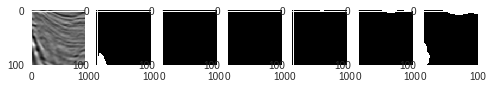

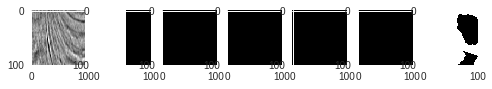

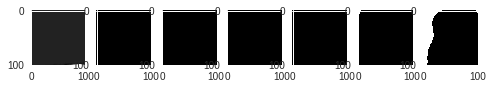

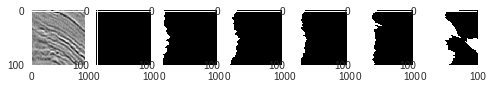

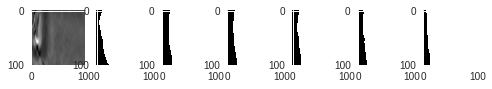

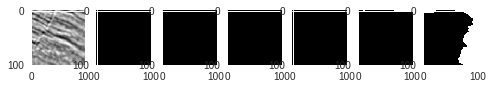

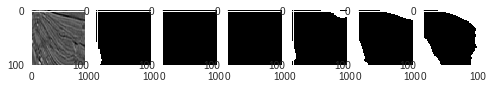

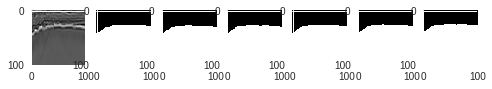

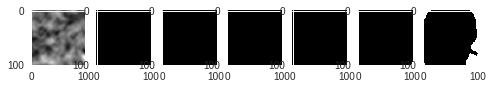

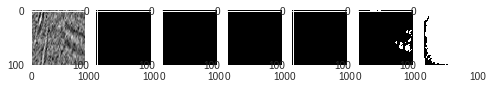

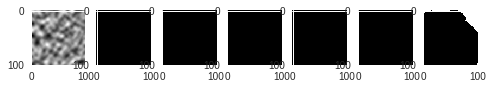

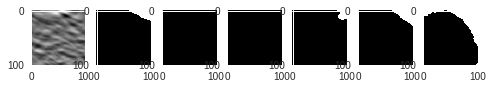

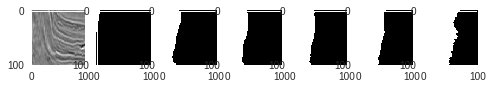

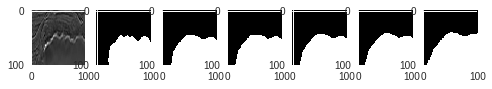

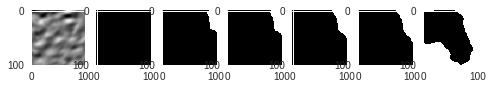

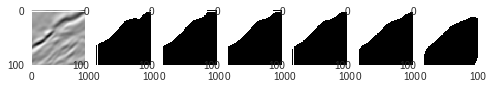

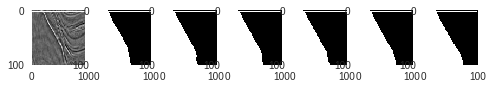

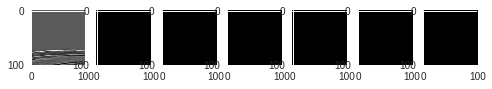

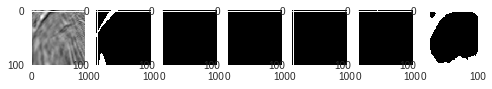

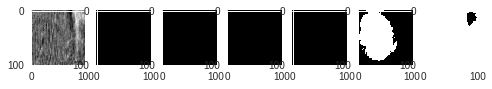

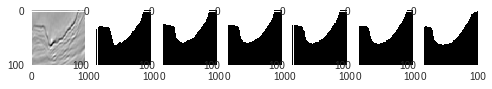

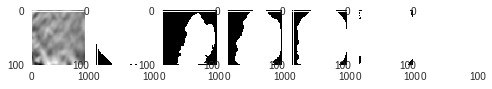

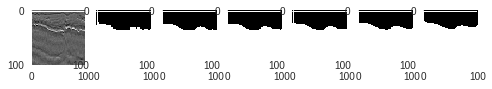

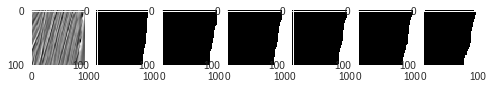

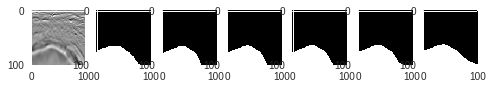

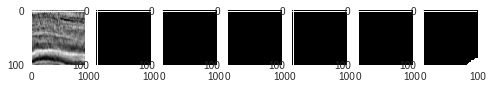

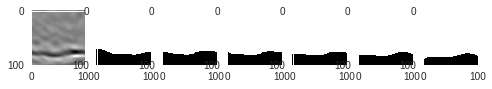

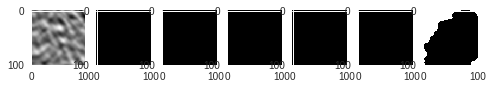

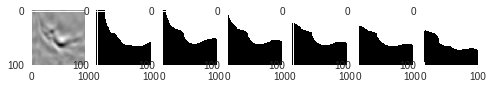

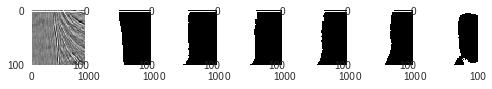

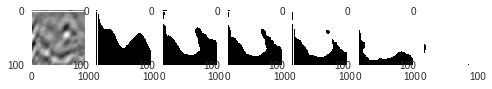

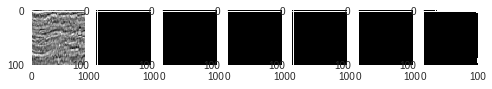

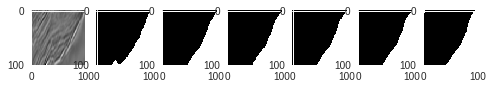

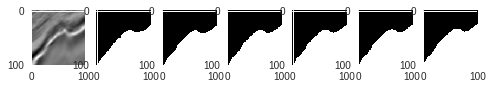

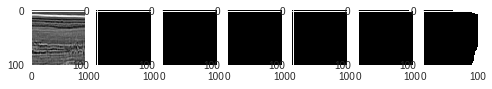

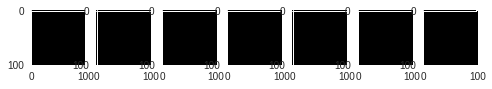

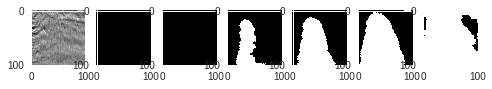

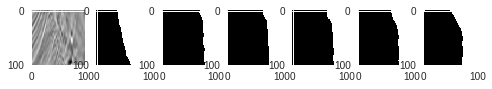

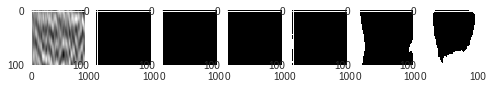

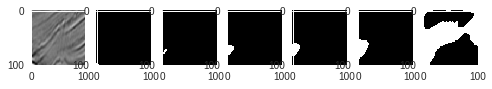

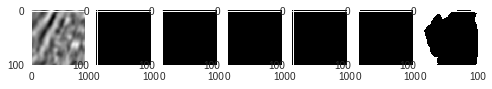

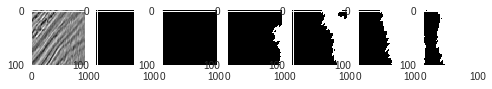

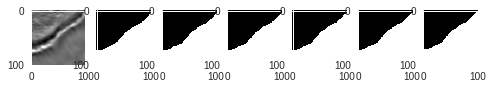

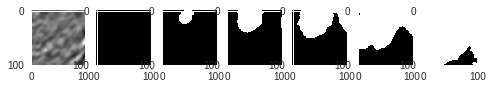

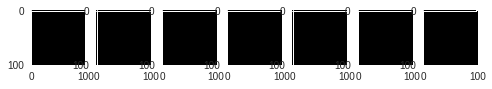

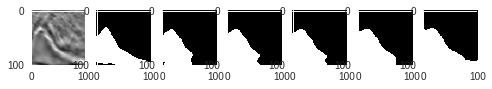

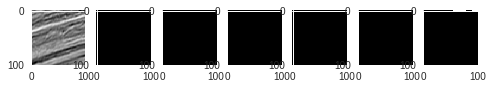

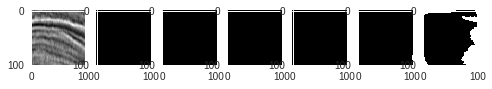

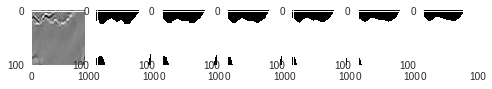

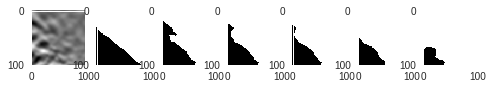

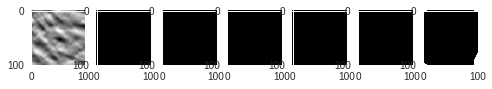

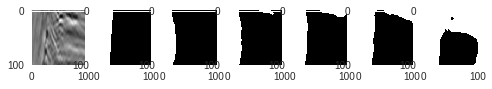

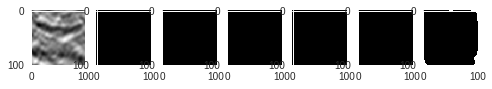

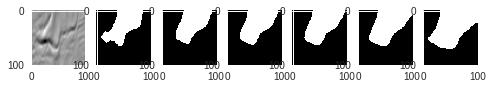

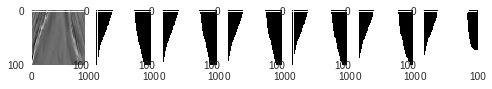

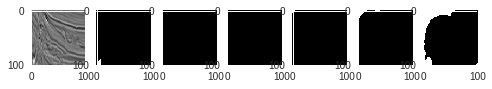

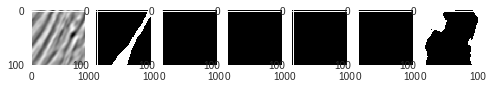

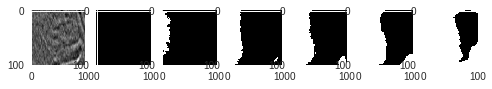

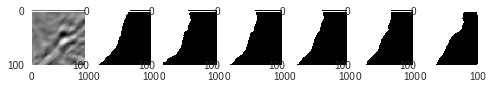

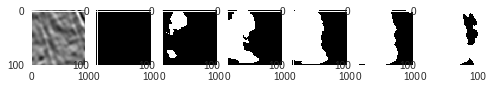

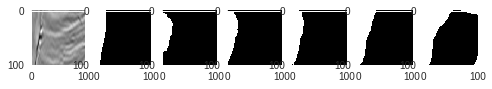

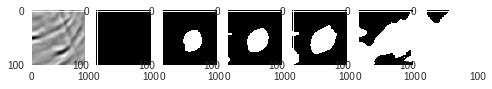

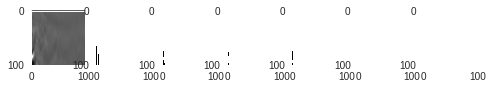

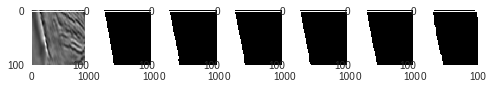

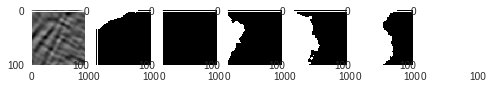

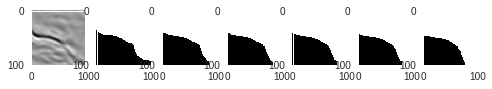

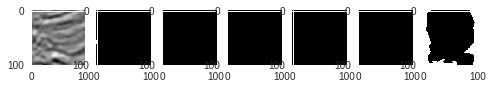

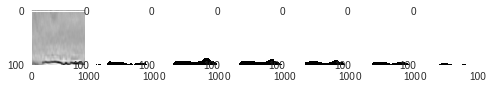

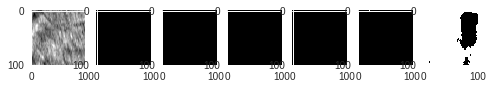

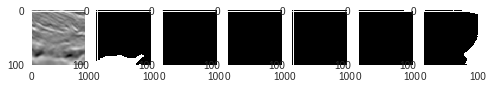

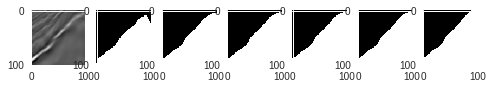

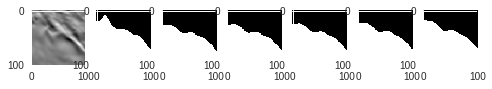

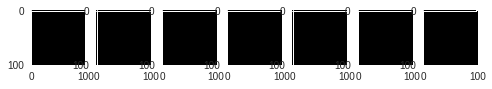

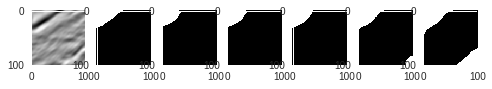

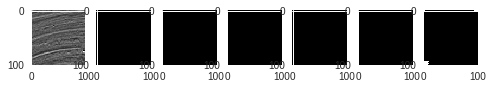

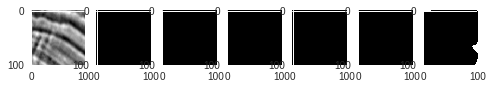

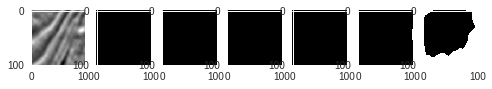

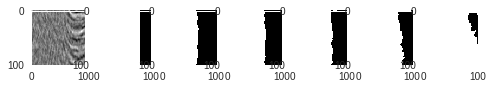

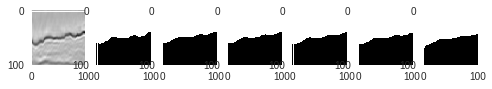

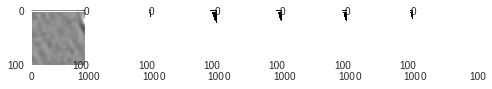

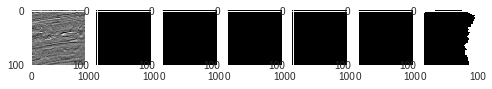

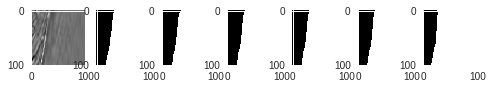

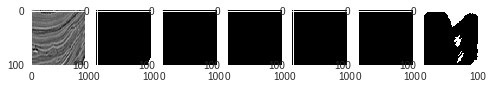

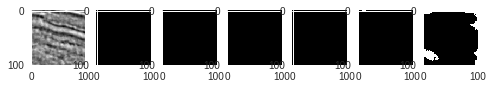

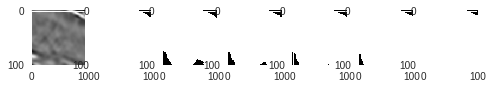

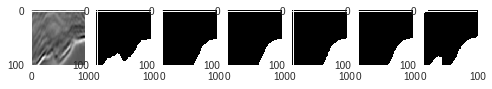

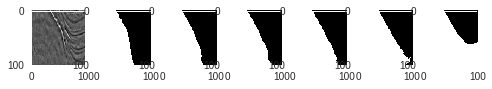

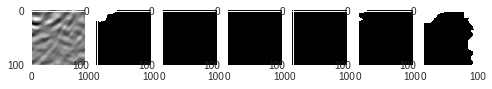

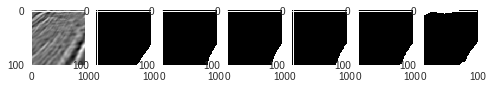

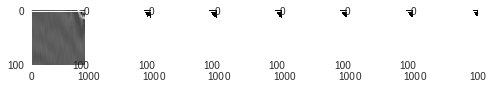

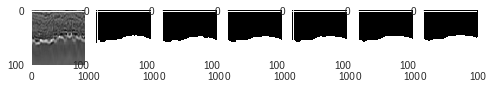

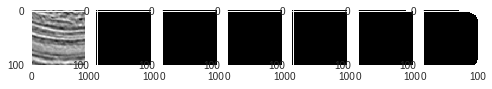

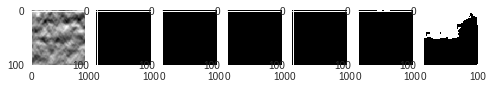

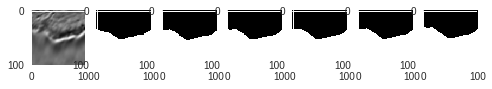

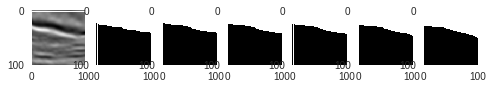

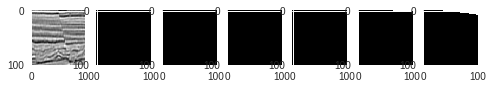

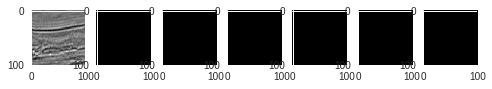

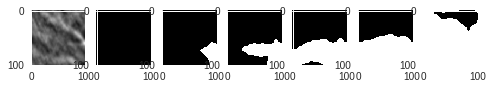

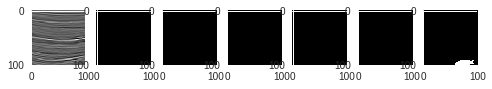

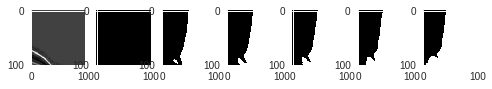

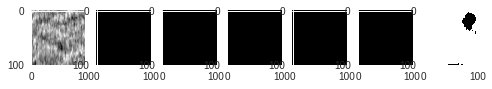

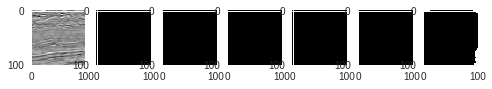

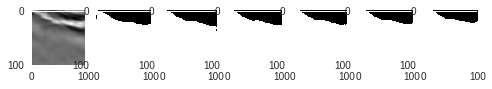

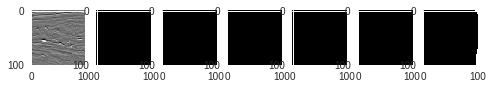

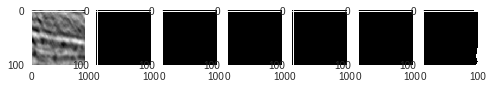

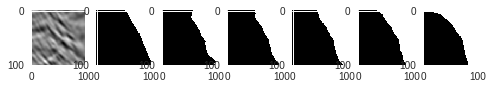

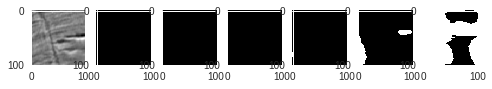

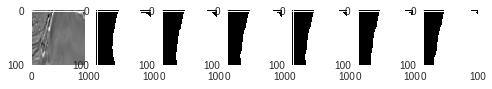

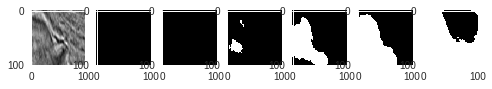

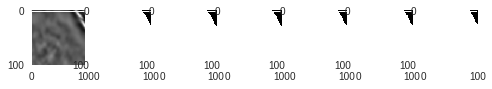

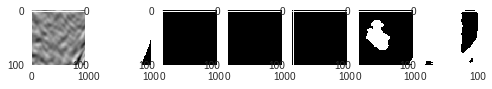

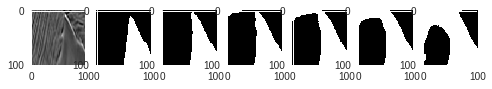

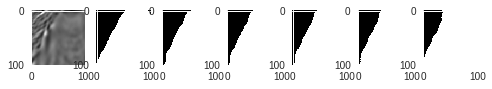

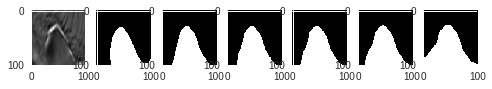

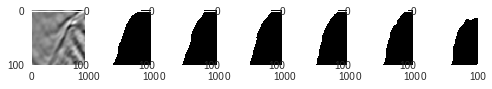

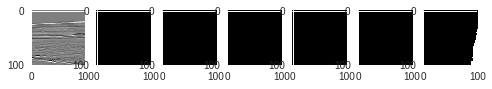

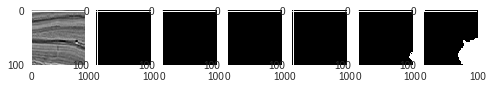

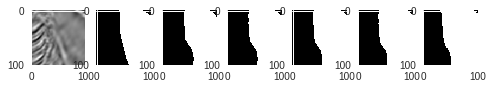

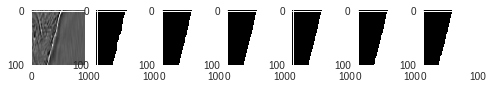

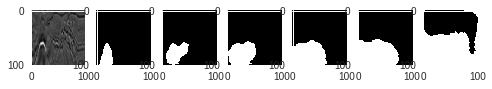

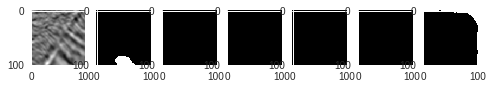

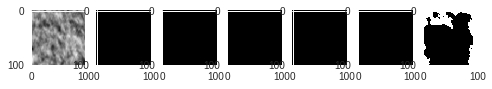

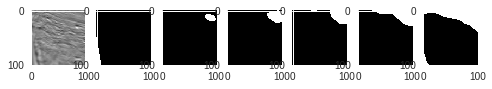

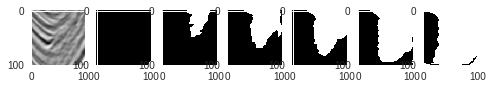

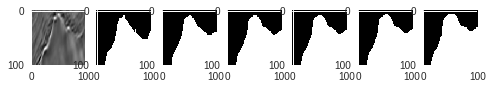

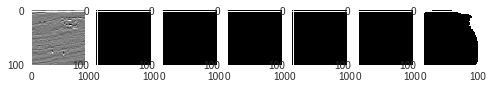

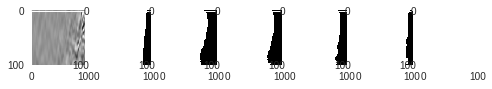

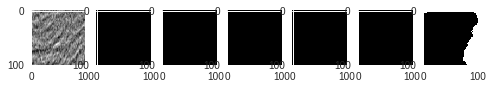

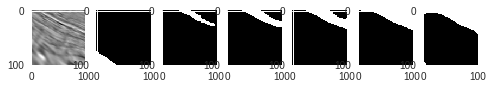

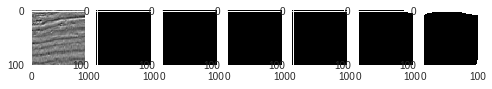

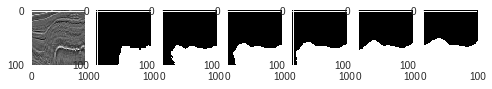

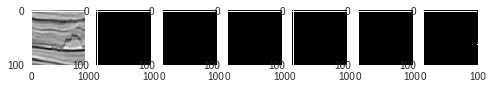

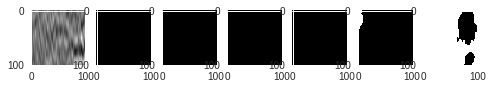

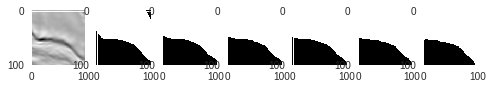

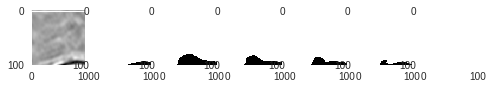

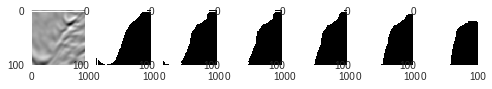

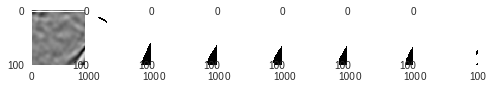

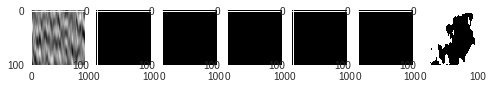

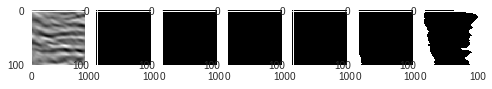

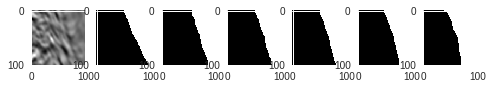

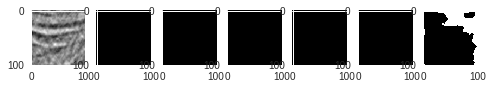

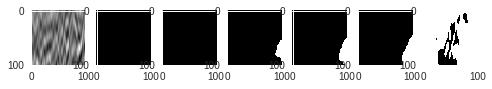

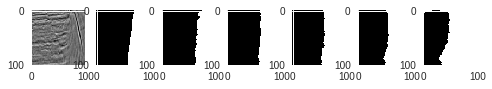

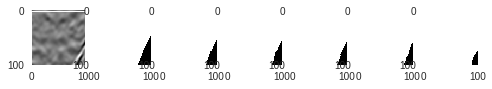

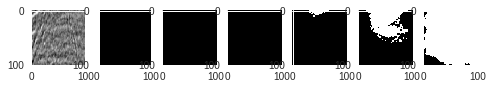

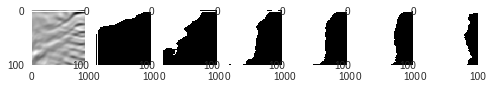

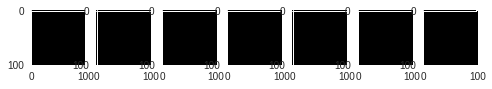

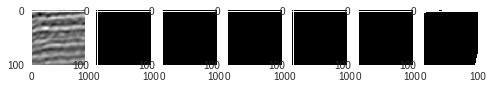

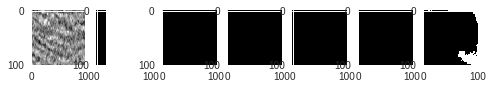

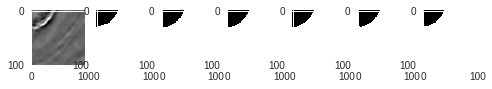

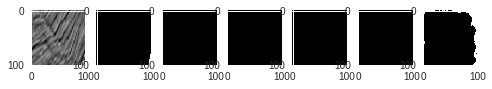

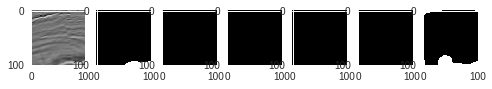

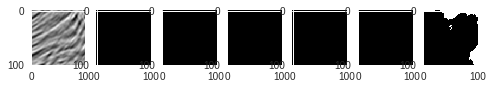

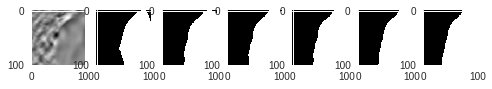

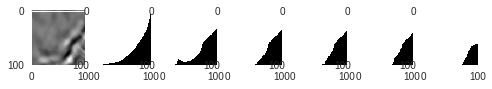

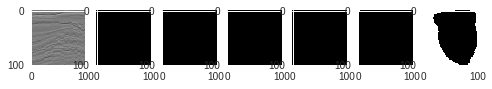

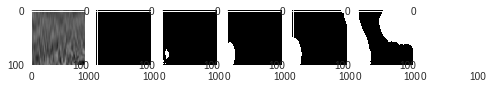

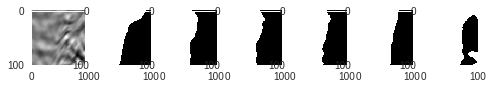

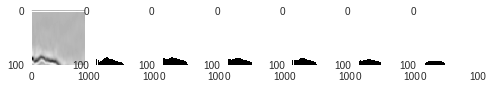

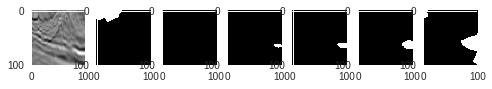

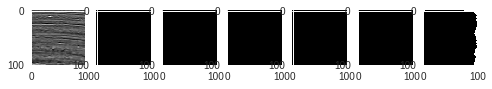

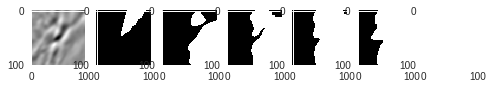

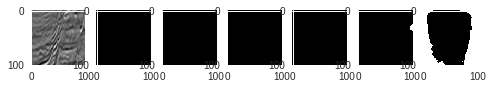

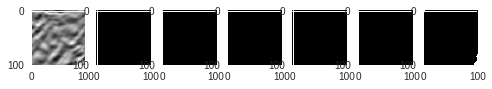

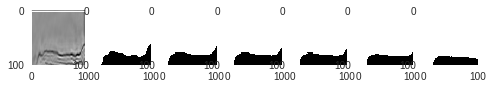

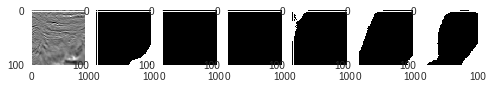

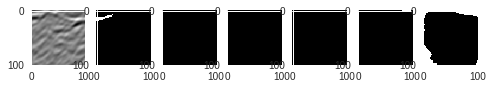

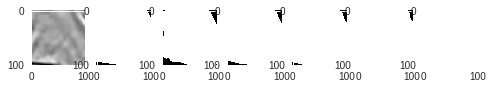

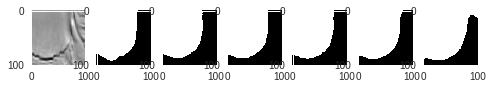

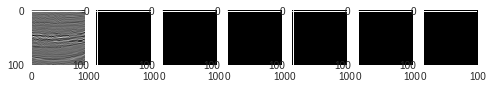

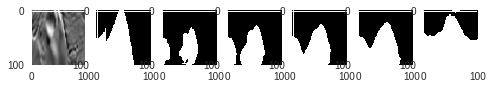

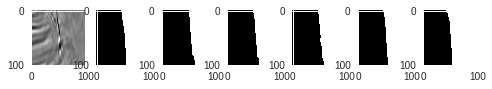

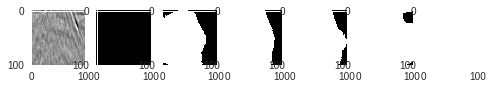

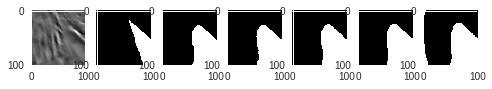

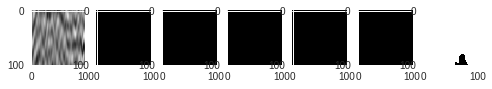

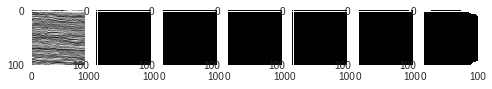

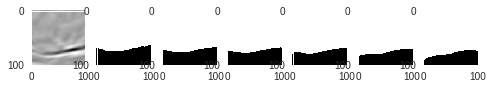

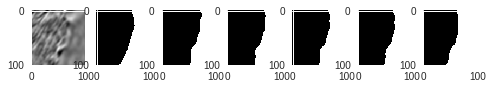

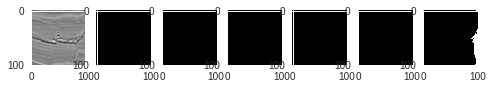

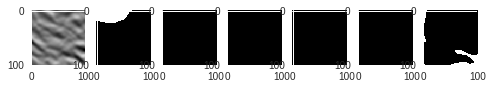

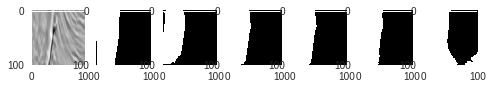

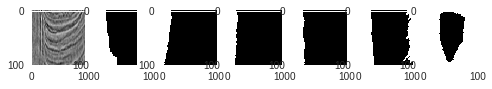

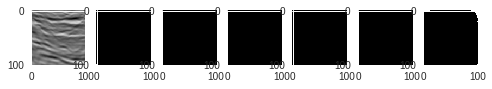

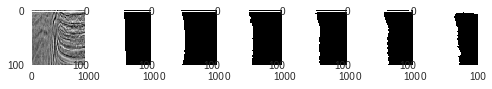

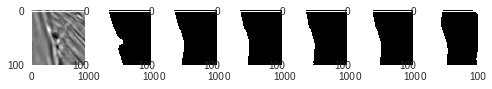

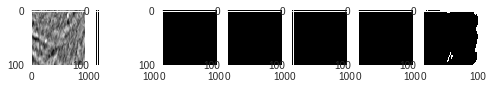

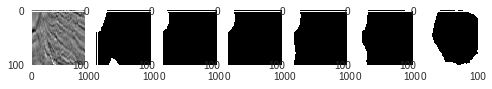

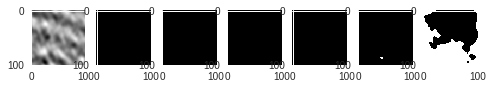

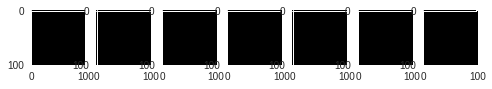

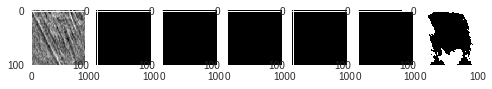

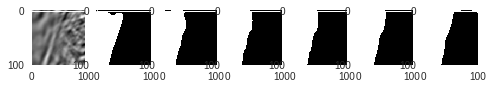

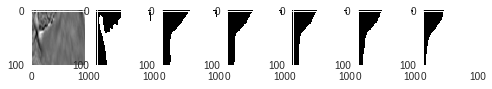

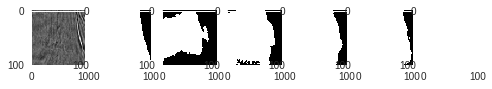

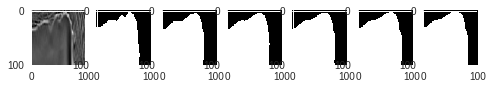

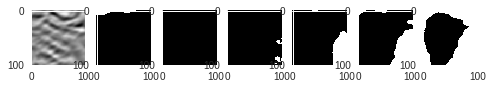

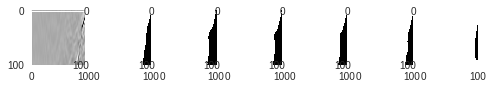

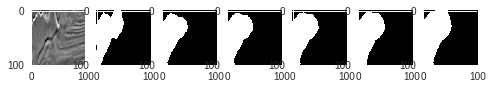

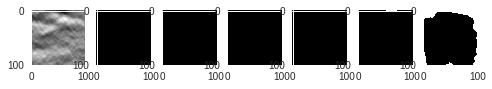

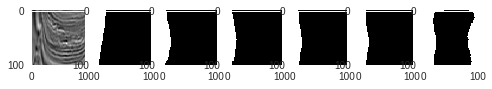

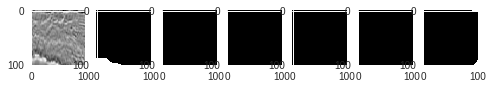

In [26]:
for i in range(len(y_val_pred)):
  fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7)
  ax1.imshow(x_val[i,:,:,0], cmap='binary_r', vmin=0, vmax=1)
  ax2.imshow(y_val[i,:,:,0], cmap='binary_r', vmin=0, vmax=1)
  ax3.imshow(np.round(y_val_pred[i,:,:,0]), cmap='binary_r', vmin=0, vmax=1)
  ax4.imshow(np.round(y_val_pred[i,:,:,0]+.15), cmap='binary_r', vmin=0, vmax=1)
  ax5.imshow(np.round(y_val_pred[i,:,:,0]+.25), cmap='binary_r', vmin=0, vmax=1)
  ax6.imshow(np.round(y_val_pred[i,:,:,0]+.35), cmap='binary_r', vmin=0, vmax=1)
  ax7.imshow(np.round(y_val_pred[i,:,:,0]+.45), cmap='binary_r', vmin=0, vmax=1)
  plt.show()

In [0]:
os.chdir('/')
!mkdir train
!mv images train/images

zip_ref = zipfile.ZipFile('test.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [31]:
ls -1|wc -l

31


In [0]:
test_image_dir = os.chdir('/images')
test_im = os.listdir(test_image_dir)
x_test = np.array([np.array(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) for p in test_im]) / 255
x_test = np.expand_dims(x_test, axis=3)

In [33]:
x_test_pred = model.predict(x_test, verbose=1)

18000/18000 [==============================] - 151s 8ms/step


In [0]:
x_test_final = np.round(x_test_pred[:,:,:,0])#+.25)

In [0]:
import csv 

def format_converter(input_matrix_set):
    """
    Converts an array of matrices into an array of strings of the locations and counts of 1's: 
    i.e. the format required by kaggle.
    For e.g.
    >>> sample = np.array([[[0, 0, 1], [1, 1, 1], [0, 1, 0]],
                [[1, 0, 1], [1, 1, 1], [0, 1, 0]],
                [[1, 1, 1], [1, 0, 1], [0, 1, 0]]])
    >>> format_converter(sample)
    ['2 1 5 4', '1 2 5 4', '1 2 4 1 6 3']
    """
    final_string = []
    for element in input_matrix_set:
        
        locations = []
        counters = []
        loc_count = []

        array = np.transpose(element).flatten()
        if array[0]==1:
            locations.append(1)
            counters.append(1)

        for i in range(1,len(array)):
            if array[i] == 1:
                if array[i-1] == 0:
                    locations.append(i+1)
                    counters.append(1)
                else:
                    counters[-1] += 1   

        for i in range(len(locations)):
            loc_count.append(locations[i])
            loc_count.append(counters[i])
    
        string = ' '.join(str(l) for l in loc_count)    
        final_string.append(string)
    
    return final_string


In [0]:
the_string = format_converter(x_test_final)

file_name = [word.split('.')[0] for word in test_im]

with open('submission.csv', 'w', newline ='') as csvfile:
	writer = csv.writer(csvfile)
	writer.writerow(['id', 'rle_mask'])
	for i in range(len(file_name)):
		writer.writerow([file_name[i], the_string[i]])

files.download('submission.csv')     

In [25]:
print('min: {:2f},\n''max: {:2f}'.format(y_val_pred.min(),y_val_pred.max()))

min: 0.000000,
max: 1.000000


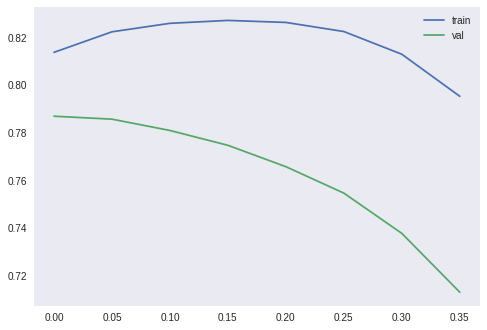

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


mean IOU training: 0.8224711993983382
mean IOU validation: 0.7545996989978238
loss training: nan
loss validation: nan


In [29]:
### Evaluate results:
y_train_reshape = y_train.reshape(-1)[:(400*101*101)]
y_train_pred_reshape = y_train_pred.reshape(-1)[:(400*101*101)]
y_val_reshape = y_val.reshape(-1)
y_val_pred_reshape = y_val_pred.reshape(-1)

true_positive_train = []
false_positive_train = []
false_negative_train = []
iou_train = []
true_positive_val = []
false_positive_val = []
false_negative_val = []
iou_val = []
thresh = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

for i in thresh:
    y_train_pred_bin = np.round(y_train_pred_reshape + i, 0)
    y_val_pred_bin = np.round(y_val_pred_reshape + i, 0)
    conf_train = confusion_matrix(y_train_pred_bin, y_train_reshape)
    true_positive_train.append(conf_train[1,1])
    false_positive_train.append(conf_train[1,0])
    false_negative_train.append(conf_train[0,1])
    iou_train.append(conf_train[1,1]/(conf_train[1,1]+conf_train[1,0]+conf_train[0,1]))
    conf_val = confusion_matrix(y_val_pred_bin, y_val_reshape)
    true_positive_val.append(conf_val[1,1])
    false_positive_val.append(conf_val[1,0])
    false_negative_val.append(conf_val[0,1])
    iou_val.append(conf_val[1,1]/(conf_val[1,1]+conf_val[1,0]+conf_val[0,1]))

d = {'true_positive_train': true_positive_train, 'false_positive_train':  \
     false_positive_train, 'false_negative_train': false_negative_train, \
     'iou_train': iou_train, 'true_positive_val': true_positive_val, 'false_positive_val':  \
     false_positive_val, 'false_negative_val': false_negative_val, 'iou_val': iou_val, }
df = pd.DataFrame.from_dict(d, orient='index')
df.columns = ['-0.1', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3', '0.35']
plt.plot(thresh, iou_train) 
plt.plot(thresh, iou_val)
plt.legend(['train', 'val'])
plt.grid()
plt.show()

i = 0.0 # <- lower threshold for positive predictions (i.e: i=0.1 --> threshold=0.4)
y_train_pred_bin = np.round(y_train_pred_reshape + i, 0)
y_val_pred_bin = np.round(y_val_pred_reshape + i, 0)
loss_train = log_loss(y_train_reshape, y_train_pred_reshape)
loss_val = log_loss(y_val_reshape, y_val_pred_reshape)               

print('mean IOU training: ' + str(iou_train[5]))
print('mean IOU validation: ' + str(iou_val[5]))
print('loss training: ' + str(loss_train))
print('loss validation: ' + str(loss_val))

In [24]:
i = 0.0 # <- lower threshold for positive predictions (i.e: i=0.1 --> threshold=0.4)
y_train_pred_bin = np.round(y_train_pred_reshape + i, 0)
y_val_pred_bin = np.round(y_val_pred_reshape + i, 0)
loss_train = log_loss(y_train_reshape, y_train_pred_reshape)
loss_val = log_loss(y_val_reshape, y_val_pred_reshape)               

print('mean IOU training: ' + str(iou_train[5]))
print('mean IOU validation: ' + str(iou_val[0]))
print('loss training: ' + str(loss_train))
print('loss validation: ' + str(loss_val))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


mean IOU training: 0.8224711993983382
mean IOU validation: 0.7869027957218396
loss training: nan
loss validation: nan


In [33]:
# ##### save model and weights
# # https://stackoverflow.com/questions/48924165/google-colaboratory-weight-download-export-saved-models
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # 1. Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# # 2. Save Keras Model or weights on google drive
# # create on Colab directory
# model.save('model_lr_4_20.h5')    
# model_file = drive.CreateFile({'title' : 'model_lr_4_20.h5'})
# model_file.SetContentFile('model_lr_4_20.h5')
# model_file.Upload()
# drive.CreateFile({'id': model_file.get('id')})
# model.save_weights('model_weights_lr_4_20.h5')
# weights_file = drive.CreateFile({'title' : 'model_weights_lr_4_20.h5'})
# weights_file.SetContentFile('model_weights_lr_4_20.h5')
# weights_file.Upload()
# drive.CreateFile({'id': weights_file.get('id')})

KeyboardInterrupt: ignored